# Project Goal
 Determine whether identified solar systems contain exoplanets. 
 Datasets show lux values of stars collected at constant time intervals.

In [1]:
# import libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import roc_auc_score, roc_curve
from hampel import hampel
import re

In [2]:
# importing dataset
df = pd.read_csv("exoTrain.csv")
df_valid = pd.read_csv("exoTest.csv")
df.head(5)

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,2,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,2,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,2,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54


In [3]:
print ("class counts from whole data")
print (df["LABEL"].value_counts())

class counts from whole data
1    5050
2      37
Name: LABEL, dtype: int64


The vast difference between exoplanets and nonexoplanets suggest that this data is highly imbalanced.

## Tidying Dataset

In [4]:
# applying index to indice solar systems
df['System'] = df.index
df_valid['System'] = df_valid.index

# change identifying labels 1-2 to 0-1
df['LABEL']=df['LABEL']-1
df_valid['LABEL']=df_valid['LABEL']-1

# apllying melt to flux columns
df = (df.melt(id_vars=['System','LABEL'], var_name=['Period'], value_name='Flux_Value'))
df_valid = (df_valid.melt(id_vars=['System','LABEL'], var_name=['Period'], value_name='Flux_Value'))

# flux periods to period
df.update(pd.DataFrame({'Period': np.ravel([list(map(int, re.findall(r'\d+', i))) for i in df['Period']])}))
df_valid.update(pd.DataFrame({'Period': np.ravel([list(map(int, re.findall(r'\d+', i))) for i in df_valid['Period']])}))

df

,System,LABEL,Period,Flux_Value
0,0,1,1,93.85
1,1,1,1,-38.88
2,2,1,1,532.64
3,3,1,1,326.52
4,4,1,1,-1107.21
...,...,...,...,...
16263134,5082,0,3197,19.28
16263135,5083,0,3197,35.58
16263136,5084,0,3197,79.43
16263137,5085,0,3197,-2.55


In [5]:
print ("class counts from pivoted data")
print (df["LABEL"].value_counts())

class counts from pivoted data
0    16144850
1      118289
Name: LABEL, dtype: int64


### Visualizing Data

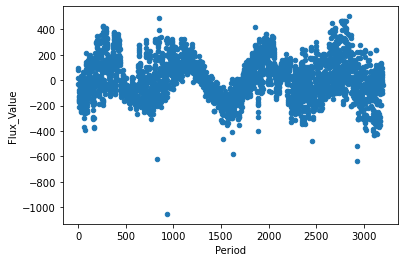

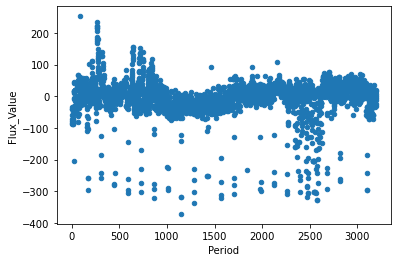

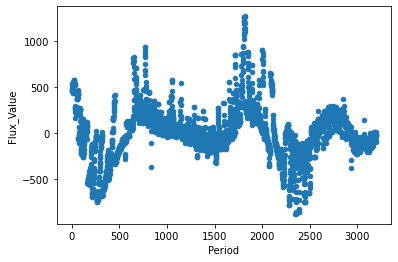

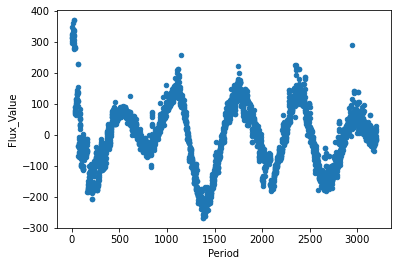

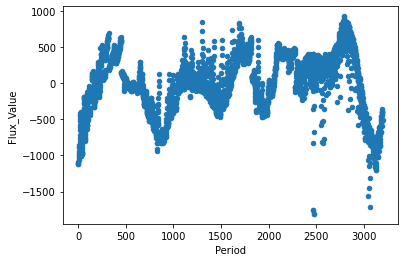

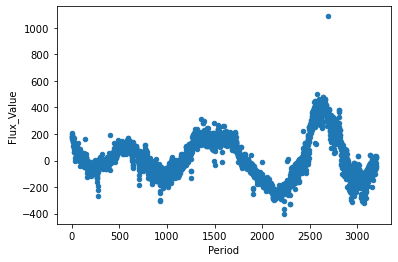

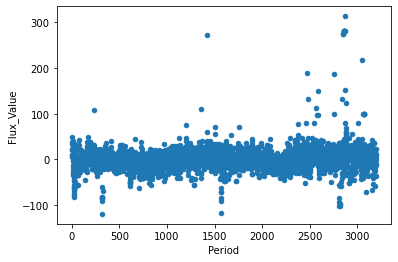

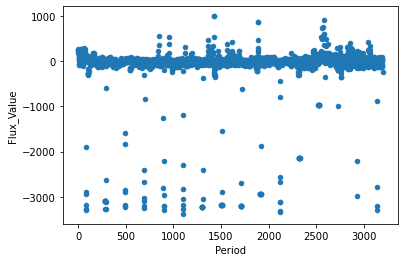

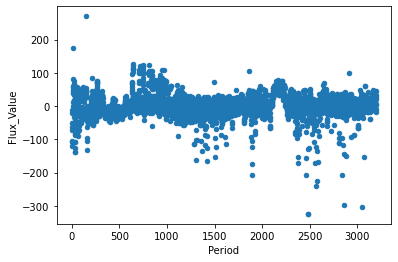

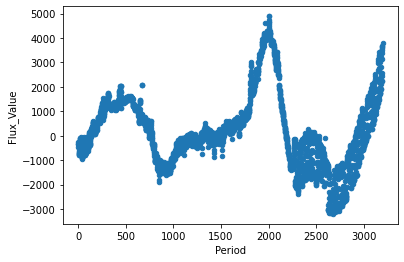

In [6]:
# Scatterplots of solar systems containing exoplanets
for i in range(10):
    df[df['System'] == i].plot.scatter(x = 'Period',
                                       y = 'Flux_Value')

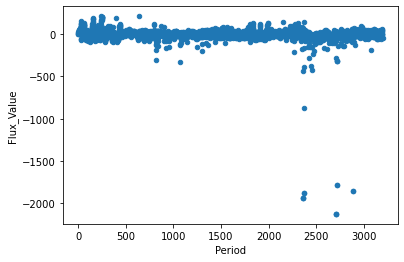

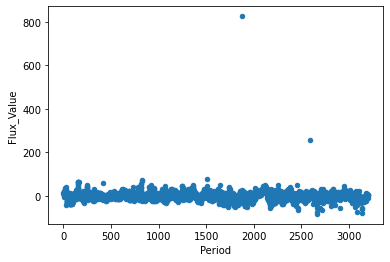

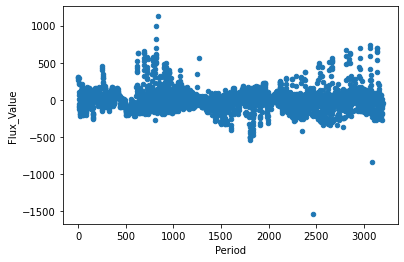

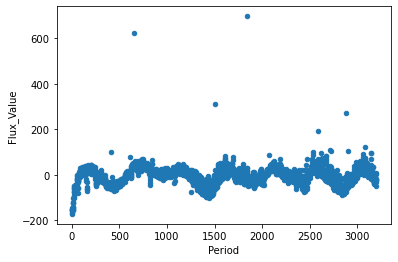

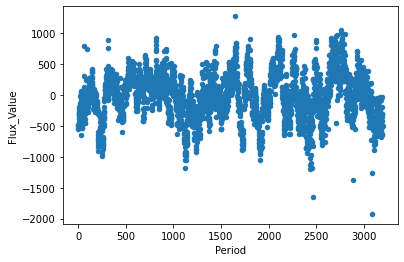

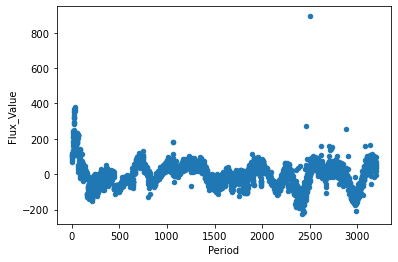

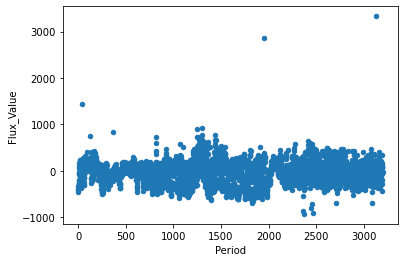

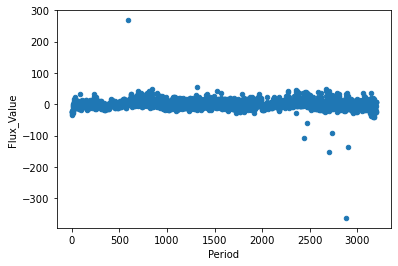

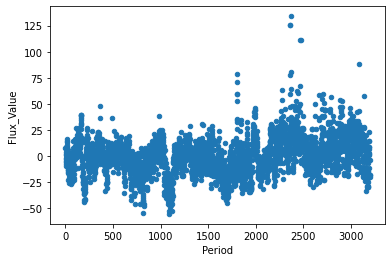

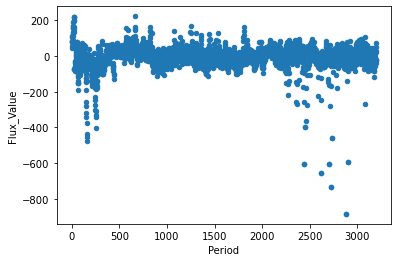

In [7]:
# Scatterplots of solar systems not containing exoplanets
for i in range(10):
    df[df['System'] == (i+100)].plot.scatter(x = 'Period',
                                             y = 'Flux_Value')

Note that by visualing the data, possible outliers become more apparent as well as the amount of noies recorded in data. 


## Data Preprocessing

### Remove Outliers

In [8]:
df = df.sort_values(by=['System', 'Period'])

In [9]:
fixed_out = []

for i in range(df.max().System + 1):
    df_system = df.query('System == @i').reset_index(drop=True).copy()
    flux_ser = pd.Series(df_system.Flux_Value)
    flux_ser_out = hampel(flux_ser, imputation=True, n=2)
    fixed_out.append(flux_ser_out.tolist())

In [10]:
fixed_out_ser = list(np.concatenate(fixed_out).flat)
len(fixed_out_ser)

16263139

In [11]:
df['Flux_Value'] = fixed_out_ser
df_adj = df.copy()
df_adj

,System,LABEL,Period,Flux_Value
0,0,1,1,93.85
5087,0,1,2,83.81
10174,0,1,3,20.10
15261,0,1,4,-26.98
20348,0,1,5,-39.56
...,...,...,...,...
16242790,5086,0,3193,-25.33
16247877,5086,0,3194,-41.31
16252964,5086,0,3195,-16.72
16258051,5086,0,3196,-14.09


### Revisualize Data

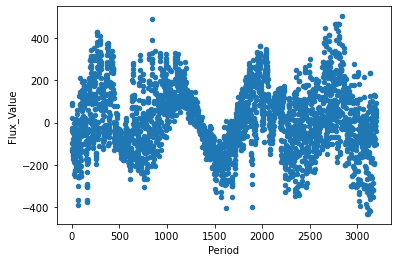

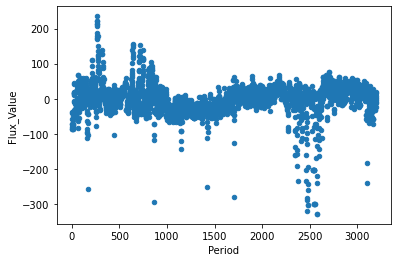

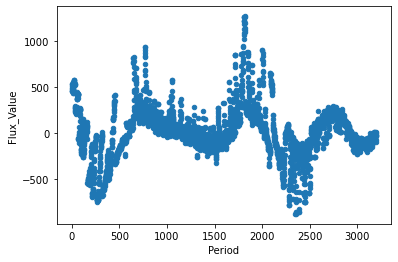

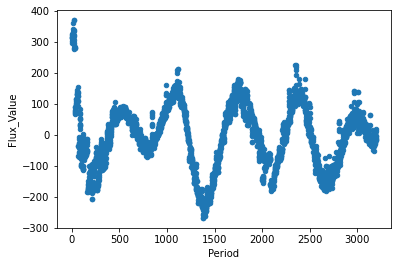

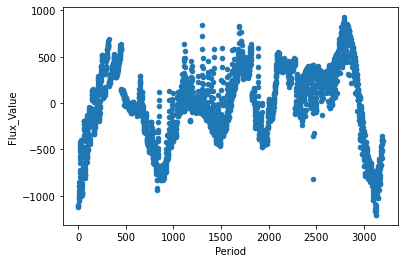

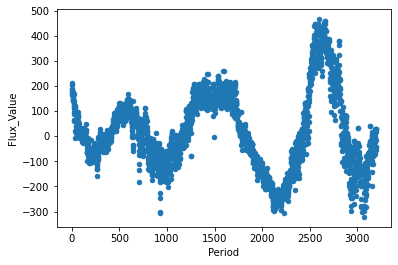

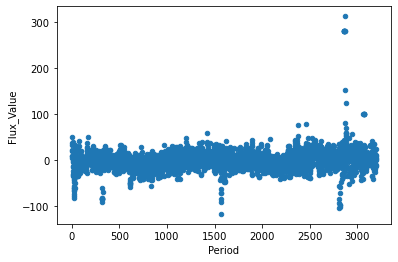

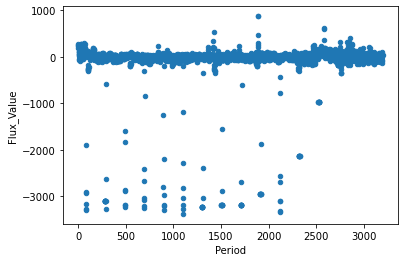

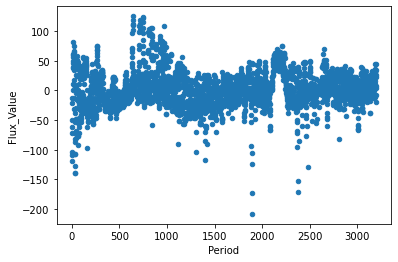

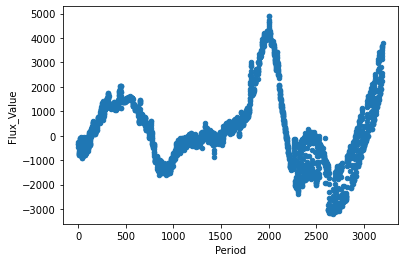

In [12]:
# Scatterplots of solar systems containing exoplanets
for i in range(10):
    df_adj[df_adj['System'] == i].plot.scatter(x = 'Period',
                                       y = 'Flux_Value')

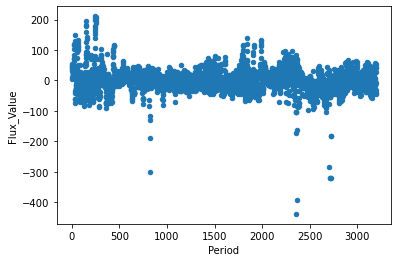

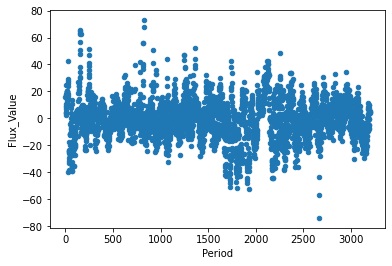

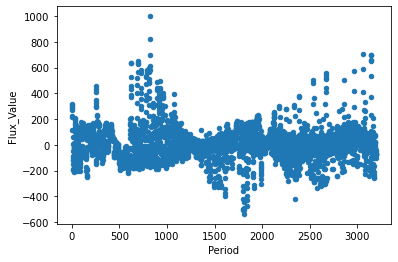

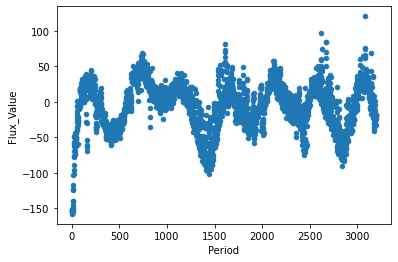

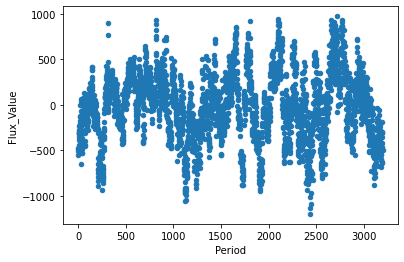

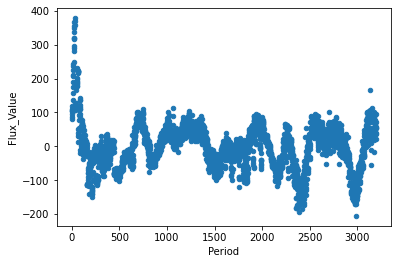

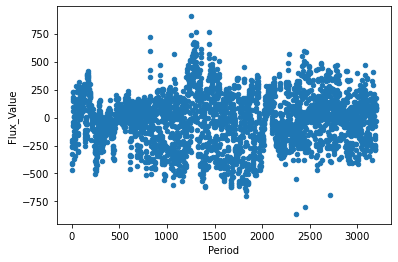

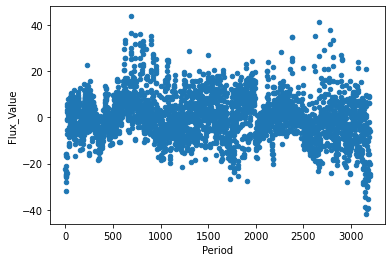

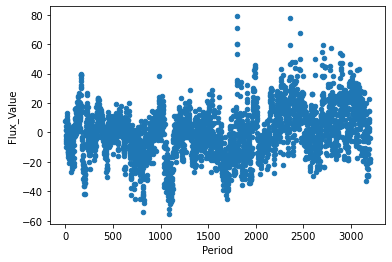

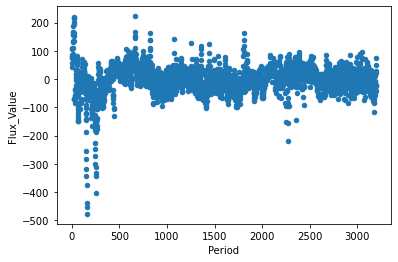

In [13]:
# Scatterplots of solar systems not containing exoplanets
for i in range(10):
    df_adj[df_adj['System'] == (i+100)].plot.scatter(x = 'Period',
                                             y = 'Flux_Value')

## Create Training, Testing, and Validation Sets

In [14]:
# train/test = 70/30
train_x, test_x, train_y, test_y = train_test_split(df_adj.drop('LABEL', axis=1), df_adj['LABEL'], test_size=0.3, stratify=df_adj['LABEL'],random_state=59)

# train_x = df.drop('LABEL', axis=1).copy()
# train_y = df['LABEL']

# validation sets
valid_x = df_valid.drop('LABEL', axis=1).copy()
valid_y = df_valid['LABEL']

In [15]:
print(train_x.head(5))
print(train_x.shape)
print(train_y.head(5))
print(train_y.shape)
print(train_y.value_counts())

          System Period  Flux_Value
11949642     279   2350      140.42
2628731     3839    517      -10.19
10157283    3631   1997      -13.30
14156881    4847   2783       16.97
2254186      645    444       31.85
(11384197, 3)
11949642    0
2628731     0
10157283    0
14156881    0
2254186     0
Name: LABEL, dtype: int64
(11384197,)
0    11301395
1       82802
Name: LABEL, dtype: int64


In [16]:
print(test_x.head(5))
print(test_x.shape)
print()
print(test_y.head(5))
print(test_y.shape)
print(test_y.value_counts())

          System Period  Flux_Value
5935983     4541   1167      592.37
7449276     1908   1465  -103237.88
10490035     641   2063      -17.68
4068603     4090    800      -11.31
7479612     1722   1471       -4.91
(4878942, 3)

5935983     0
7449276     0
10490035    0
4068603     0
7479612     0
Name: LABEL, dtype: int64
(4878942,)
0    4843455
1      35487
Name: LABEL, dtype: int64


In [17]:
print(valid_x.head(5))
print(valid_y.head(5))
print(valid_x.shape)
print(valid_y.shape)
print(valid_y.value_counts())

   System Period  Flux_Value
0       0      1      119.88
1       1      1     5736.59
2       2      1      844.48
3       3      1     -826.00
4       4      1      -39.57
0    1
1    1
2    1
3    1
4    1
Name: LABEL, dtype: int64
(1822290, 3)
(1822290,)
0    1806305
1      15985
Name: LABEL, dtype: int64


Need to figure out a way to shrink data set

### Undersample Majority Class to reduce bias

In [18]:
undersample = RandomUnderSampler(sampling_strategy='majority')
train_x_under, train_y_under = undersample.fit_resample(train_x, train_y)
print(train_y_under.value_counts())
print(train_x_under.shape)

0    82802
1    82802
Name: LABEL, dtype: int64
(165604, 3)


## Bullding Models

###### Calculation Function

In [19]:
# AUC ROC function to more accuratlely measure imbalanced data
def plot_roc_curve(y_prob, y_true):

    fpr, tpr, thresholds = roc_curve(y_prob, y_true)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

### Decision Tree

###### Train Model

In [20]:
from sklearn import tree
clf_tree = tree.DecisionTreeClassifier(random_state=121212)
# train/build model
clf_tree = clf_tree.fit(train_x_under, train_y_under)

###### Predicting Testing Data

f1:1.0
accuracy:1.0
precision:1.0
recall:1.0

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   4843455
           1       1.00      1.00      1.00     35487

    accuracy                           1.00   4878942
   macro avg       1.00      1.00      1.00   4878942
weighted avg       1.00      1.00      1.00   4878942

Decision Tree AUC score: 1.0


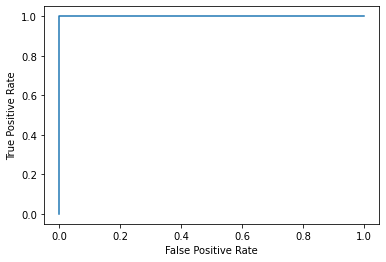

In [21]:
# calculate predictions
pred_tree_y = clf_tree.predict(test_x)

# evaluate prediction results
print ("f1:" + str(f1_score(pred_tree_y, test_y)))
print ("accuracy:" + str(accuracy_score(pred_tree_y, test_y)))
print ("precision:" + str(precision_score(pred_tree_y, test_y)))
print ("recall:" + str(recall_score(pred_tree_y, test_y)))
print()

for line in classification_report(pred_tree_y, test_y).split("\n"):
    print (line)
    
plot_roc_curve(pred_tree_y, test_y)
print(f'Decision Tree AUC score: {roc_auc_score(pred_tree_y, test_y)}')

###### Predicting Validattion Data

f1:0.2380952380952381
accuracy:0.9438596491228071
precision:1.0
recall:0.13513513513513514

              precision    recall  f1-score   support

           0       0.94      1.00      0.97   1704001
           1       1.00      0.14      0.24    118289

    accuracy                           0.94   1822290
   macro avg       0.97      0.57      0.60   1822290
weighted avg       0.95      0.94      0.92   1822290

Decision Tree AUC score: 0.5675675675675675


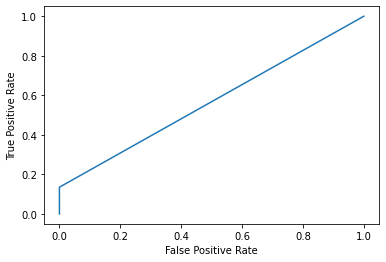

In [22]:
# calculate predictions
pred_tree_y = clf_tree.predict(valid_x)

# evaluate prediction results
print ("f1:" + str(f1_score(pred_tree_y, valid_y)))
print ("accuracy:" + str(accuracy_score(pred_tree_y, valid_y)))
print ("precision:" + str(precision_score(pred_tree_y, valid_y)))
print ("recall:" + str(recall_score(pred_tree_y, valid_y)))
print()

for line in classification_report(pred_tree_y, valid_y).split("\n"):
    print (line)
    
plot_roc_curve(pred_tree_y, valid_y)
print(f'Decision Tree AUC score: {roc_auc_score(pred_tree_y, valid_y)}')

### Random Forest

###### Train Model

In [23]:
from sklearn.ensemble import RandomForestClassifier as RFC
clf_rf = RFC(n_estimators = 50)
# train model
clf_rf.fit(train_x_under, train_y_under)

RandomForestClassifier(n_estimators=50)

###### Predict Testing Data

f1:1.0
accuracy:1.0
precision:1.0
recall:1.0

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   4843455
           1       1.00      1.00      1.00     35487

    accuracy                           1.00   4878942
   macro avg       1.00      1.00      1.00   4878942
weighted avg       1.00      1.00      1.00   4878942

Random Forest AUC score: 1.0


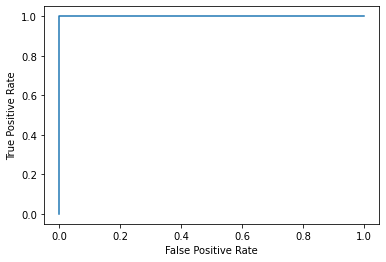

In [24]:
# calculate predictions
pred_rf_y = clf_rf.predict(test_x)

# evaluate prediction results
print ("f1:" + str(f1_score(pred_rf_y, test_y)))
print ("accuracy:" + str(accuracy_score(pred_rf_y, test_y)))
print ("precision:" + str(precision_score(pred_rf_y, test_y)))
print ("recall:" + str(recall_score(pred_rf_y, test_y)))
print()

for line in classification_report(pred_rf_y, test_y).split("\n"):
    print (line)
    
plot_roc_curve(pred_rf_y, test_y)
print(f'Random Forest AUC score: {roc_auc_score(pred_rf_y, test_y)}')

###### Predict Validation Data

f1:0.2380952380952381
accuracy:0.9438596491228071
precision:1.0
recall:0.13513513513513514

              precision    recall  f1-score   support

           0       0.94      1.00      0.97   1704001
           1       1.00      0.14      0.24    118289

    accuracy                           0.94   1822290
   macro avg       0.97      0.57      0.60   1822290
weighted avg       0.95      0.94      0.92   1822290

Random Forest AUC score: 0.5675675675675675


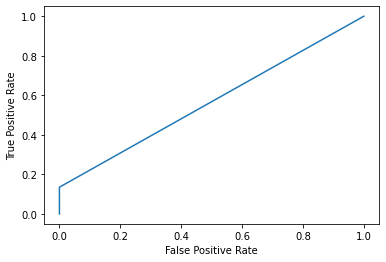

In [25]:
# calculate predictions
pred_rf_y = clf_rf.predict(valid_x)

# evaluate prediction results
print ("f1:" + str(f1_score(pred_rf_y, valid_y)))
print ("accuracy:" + str(accuracy_score(pred_rf_y, valid_y)))
print ("precision:" + str(precision_score(pred_rf_y, valid_y)))
print ("recall:" + str(recall_score(pred_rf_y, valid_y)))
print()

for line in classification_report(pred_rf_y, valid_y).split("\n"):
    print (line)
    
plot_roc_curve(pred_rf_y, valid_y)
print(f'Random Forest AUC score: {roc_auc_score(pred_rf_y, valid_y)}')

### Logistic Regression

###### Train Model

In [26]:
from sklearn.linear_model import LogisticRegression
clf_log = LogisticRegression()
# train model
clf_log = clf_log.fit(train_x_under, train_y_under)

###### Predict Testing Data

f1:0.9999859101348401
accuracy:0.9999997950375307
precision:0.9999718206667231
recall:1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   4843456
           1       1.00      1.00      1.00     35486

    accuracy                           1.00   4878942
   macro avg       1.00      1.00      1.00   4878942
weighted avg       1.00      1.00      1.00   4878942

Random Forest AUC score: 0.9999998967679278


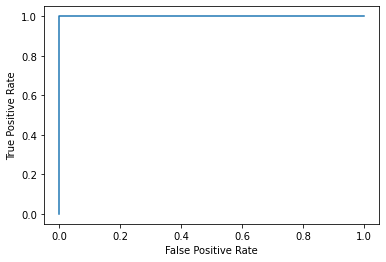

In [34]:
# make prediction
pred_log_y = clf_log.predict(test_x)
# evaluate the prediction results
print ("f1:" + str(f1_score(pred_log_y, test_y)))
print ("accuracy:" + str(accuracy_score(pred_log_y, test_y)))
print ("precision:" + str(precision_score(pred_log_y, test_y)))
print ("recall:" + str(recall_score(pred_log_y, test_y)))

for line in classification_report(pred_log_y, test_y).split("\n"):
    print (line)
    
plot_roc_curve(pred_log_y, test_y)
print(f'Random Forest AUC score: {roc_auc_score(pred_log_y, test_y)}')

###### Predicting Validation Data

f1:0.23774642859798764
accuracy:0.9437515433877155
precision:1.0
recall:0.13491045355569434
              precision    recall  f1-score   support

           0       0.94      1.00      0.97   1704001
           1       1.00      0.14      0.24    118289

    accuracy                           0.94   1822290
   macro avg       0.97      0.57      0.60   1822290
weighted avg       0.95      0.94      0.92   1822290

Linear Regression AUC score: 0.5675675675675675


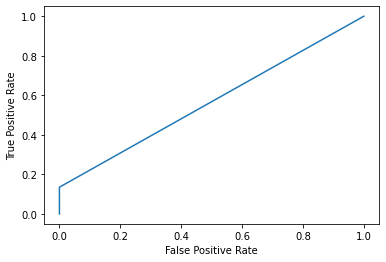

In [28]:
# make prediction
pred_log_y = clf_log.predict(valid_x)
# evaluate the prediction results
print ("f1:" + str(f1_score(pred_log_y, valid_y)))
print ("accuracy:" + str(accuracy_score(pred_log_y, valid_y)))
print ("precision:" + str(precision_score(pred_log_y, valid_y)))
print ("recall:" + str(recall_score(pred_log_y, valid_y)))

for line in classification_report(pred_rf_y, valid_y).split("\n"):
    print (line)
    
plot_roc_curve(pred_rf_y, valid_y)
print(f'Linear Regression AUC score: {roc_auc_score(pred_rf_y, valid_y)}')

### K Neigbor

###### Train Model

In [29]:
from sklearn.neighbors import KNeighborsClassifier as KN
# train model
clf_kn = KN(n_neighbors=10)
clf_kn.fit(train_x_under, train_y_under)

KNeighborsClassifier(n_neighbors=10)

###### Predict Test Data

f1:0.5539504302603427
accuracy:0.9882921338273749
precision:0.9995209513342914
recall:0.38314879827167164
              precision    recall  f1-score   support

           0       0.99      1.00      0.99   4786367
           1       1.00      0.38      0.55     92575

    accuracy                           0.99   4878942
   macro avg       0.99      0.69      0.77   4878942
weighted avg       0.99      0.99      0.99   4878942

K Neighbor AUC score: 0.6915726232586413


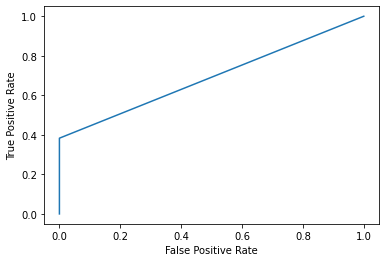

In [30]:
# calculate predictions
pred_kn_y = clf_kn.predict(test_x)
# evaluate prediction results
print ("f1:" + str(f1_score(pred_kn_y, test_y)))
print ("accuracy:" + str(accuracy_score(pred_kn_y, test_y)))
print ("precision:" + str(precision_score(pred_kn_y, test_y)))
print ("recall:" + str(recall_score(pred_kn_y, test_y)))

for line in classification_report(pred_kn_y, test_y).split("\n"):
    print (line)
    
plot_roc_curve(pred_kn_y, test_y)
print(f'K Neighbor AUC score: {roc_auc_score(pred_kn_y, test_y)}')

###### Predict Validation Data

f1:0.1084758414766558
accuracy:0.8558132898715353
precision:1.0
recall:0.05734837749116544
              precision    recall  f1-score   support

           0       0.85      1.00      0.92   1543555
           1       1.00      0.06      0.11    278735

    accuracy                           0.86   1822290
   macro avg       0.93      0.53      0.52   1822290
weighted avg       0.88      0.86      0.80   1822290

K Neighbor AUC score: 0.5286741887455827


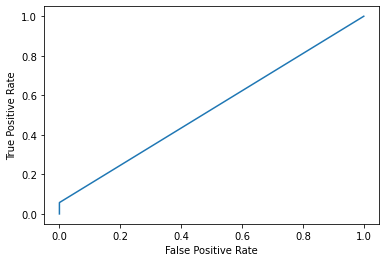

In [33]:
# calculate predictions
pred_kn_y = clf_kn.predict(valid_x)
# evaluate prediction results
print ("f1:" + str(f1_score(pred_kn_y, valid_y)))
print ("accuracy:" + str(accuracy_score(pred_kn_y, valid_y)))
print ("precision:" + str(precision_score(pred_kn_y, valid_y)))
print ("recall:" + str(recall_score(pred_kn_y, valid_y)))

for line in classification_report(pred_kn_y, valid_y).split("\n"):
    print (line)
    
plot_roc_curve(pred_kn_y, valid_y)
print(f'K Neighbor AUC score: {roc_auc_score(pred_kn_y, valid_y)}')

### Perceptron Model

###### Convert NumPy to Dataframes

In [43]:
# convert numpy arrays to data frames
df_train_x = np.asarray(train_x_under).astype('float32')
df_train_y = np.asarray(train_y_under).astype('float32')
df_test_x = np.asarray(test_x).astype('float32')
df_test_y = np.asarray(test_y).astype('float32')
df_valid_x = np.asarray(valid_x).astype('float32')
df_valid_y = np.asarray(valid_y).astype('float32')

###### Determine Dimension of Feature Reference

In [44]:
from keras.models import Sequential
from keras import layers

input_dim = train_x.shape[1]  # Number of features

model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

###### Configure Model

In [45]:
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
               metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 10)                40        
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 51
Trainable params: 51
Non-trainable params: 0
_________________________________________________________________


###### Train Model

In [38]:
history = model.fit(df_train_x, df_train_y,
                     epochs=100,
                     verbose=False,
                     validation_data=(df_valid_x, df_valid_y),
                     batch_size=10)

###### Visualize Model

In [46]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

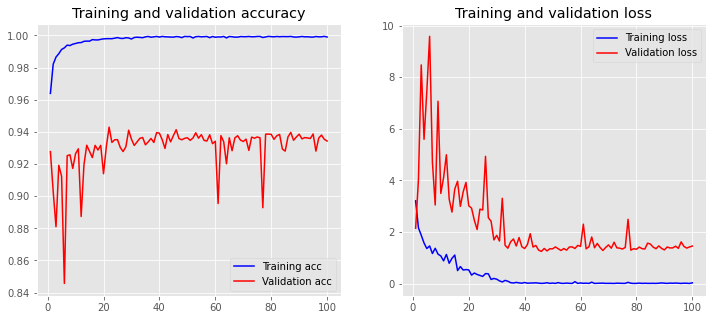

In [47]:
plot_history(history)

In [50]:
loss, accuracy = model.evaluate(df_train_x, df_train_y, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(df_test_x, df_test_y, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(df_valid_x, df_valid_y, verbose=False)
print("Validation Accuracy: {:.4f}".format(accuracy))

Training Accuracy: 0.9249
Testing Accuracy:  0.9349
Validation Accuracy: 0.4757


# Everything After this is still under development

### SVM Model

In [ ]:
from sklearn import svm
clf_svm = svm.SVC(random_state=121212, C=0.0001)
# train model
clf_svm = clf_svm.fit(train_x_under, train_y_under)
# calulate predictions
pred_svm_y = clf_svm.predict(valid_x)

# evaluate prediction results
print ("f1:" + str(f1_score(pred_svm_y, valid_y)))
print ("accuracy:" + str(accuracy_score(pred_svm_y, valid_y)))
print ("precision:" + str(precision_score(pred_svm_y, valid_y)))
print ("recall:" + str(recall_score(pred_svm_y, valid_y)))
print()

for line in classification_report(pred_svm_y, valid_y).split("\n"):
    print (line)
    
plot_roc_curve(pred_svm_y, valid_y)
print(f'SVM AUC score: {roc_auc_score(pred_svm_y, valid_y)}')

### Data Normalization

In [ ]:
# Normalize training and testing set
from sklearn.preprocessing import Normalizer
scaler = Normalizer().fit(train_x)
normtrain_x = scaler.transform(train_x)
normtest_x = scaler.transform(test_x)

# convert numpy arrays to data frames
df_normtrain_x = pd.DataFrame(normtrain_x, columns=train_x.columns)
df_normtest_x = pd.DataFrame(normtest_x, columns=test_x.columns)

print(df_normtest_x.head(5))
print(df_normtrain_x.head(5))

In [ ]:
# Normalize validation data
normvalid_x = scaler.transform(valid_x)

# convert numpy arrays to data frames
df_normvalid_x = pd.DataFrame(normvalid_x, columns=valid_x.columns)

print(df_normvalid_x.head(5))